# Solving Helmholtz equation with PINNs

In [1]:
from matplotlib import pyplot as plt

from jaxdf.geometry import Domain
from jaxdf import operators as jops
from jaxdf.core import operator
from jax import numpy as jnp
import jax

The equation we want to simulate is

$$
\left(\nabla^2 - \frac{\omega^2}{c^2} \right)u = - i\omega S_M
$$

Furthermore, to enforce the Sommerfield radiation conditions, the components of the spatial differential operators are modified as [[1]](http://oomph-lib.maths.man.ac.uk/doc/pml_helmholtz/scattering/latex/refman.pdf):

$$
\partial_{x_j} = \frac{\partial_{x_j}}{\gamma_j}
$$

where

$$
\gamma_j = 1 + \frac{\sigma_j(x)}{k_0}, \qquad \sigma_j(x) = \begin{cases}
\frac{\sigma^*\|x_j - \Delta_{PML}\|^\alpha}{\Delta_{PML}}, & \|x\| > \Delta_{PML}\\
0, & \text{otherwise} \\
\end{cases}$$

Let's start by building up the $\sigma$ function

In [67]:
domain = Domain((256, 256), (1., 1.))
omega = .25

In [68]:
from jaxdf.discretization import Coordinate
from jaxdf.core import Field

coordinate_discr = Coordinate(domain)
X = Field(coordinate_discr, params={}, name="X")

# Define PML Function
delta_pml = 100.
def sigma(X):
    on_pml = jops.elementwise(
        lambda x: jnp.where(
            jnp.abs(x) > delta_pml,
            (jnp.abs(jnp.abs(x)-delta_pml)/(128. - delta_pml)), 
            0.)
    )
    return 4.*on_pml(X)**2

def pml_factor(X):
    return 1./(1 + 1j*sigma(X)/omega)

# Define laplacian with PML
def laplacian(u, x):
    pml = pml_factor(x)
    grad_u = jops.gradient(u)
    mod_grad_u = grad_u*pml
    mod_diag_jacobian = jops.diag_jacobian(mod_grad_u)*pml
    return jops.sum_over_dims(mod_diag_jacobian)

@operator()
def helmholtz(u, c, x):
    # Get the modified laplacian
    L = laplacian(u, x)
    
    # Add the wavenumber term
    k = ((omega/c)**2)*u
    
    return L + k

In [69]:
from jaxdf.discretization import Arbitrary, UniformField
from jax.experimental import stax
from jax import random

seed = random.PRNGKey(42)

# Make a neural network for the field discretization
Sin = stax.elementwise(jnp.sin)
init_random_params, predict_p = stax.serial(
    stax.Dense(256), 
    Sin, 
    stax.Dense(256), 
    Sin, 
    stax.Dense(256), 
    Sin, 
    stax.Dense(256), 
    Sin, 
    stax.Dense(256), 
    Sin, 
    stax.Dense(2)
)

def init_params(seed, domain):
    return init_random_params(seed, (len(domain.N),))[1]

def get_fun(params, x):
    x = 30*x/128.
    p = predict_p(params, x)
    return jnp.asarray([p[0] + p[1]*1j,])

u_discr = Arbitrary(domain, get_fun, init_params)
u_params, u = u_discr.random_field(seed, name='u')

# Narrow gaussian pulse as source
def init_params(seed, domain):
    return {}

def gaussian_func(params, x):
    x = x + jnp.asarray([0,75])
    return jnp.expand_dims(jnp.exp(-jnp.sum(x**2)/8) + 0*1j, -1)

src_discr = Arbitrary(domain, gaussian_func, init_params)
src_params, src = src_discr.random_field(seed, name='src')

# Arbitrary SOS map

'''
Sin = stax.elementwise(jnp.tanh)
Treshold_shift = stax.elementwise(jax.nn.sigmoid)
Relu = stax.elementwise(jax.nn.relu)
init_random_params, predict_p = stax.serial(
    stax.Dense(128), 
    Relu, 
    stax.Dense(128), 
    Relu, 
    stax.Dense(128), 
    Relu, 
    stax.Dense(128), 
    Relu, 
    stax.Dense(128), 
    Sin, 
    stax.Dense(1),
    Treshold_shift
)

def init_params(seed, domain):
    return init_random_params(seed, (len(domain.N),))[1]

def get_fun(params, x):
    p = predict_p(params, x)*(1-jax.nn.sigmoid(jnp.abs(x[0]) - 50))*(1-jax.nn.sigmoid(jnp.abs(x[1]) - 50)) + 1
    return p

c_discr = Arbitrary(domain, get_fun, init_params)
c_params, c = c_discr.random_field(seed, name='c')
'''

# Arbitrary Speed of Sound map
def init_params(seed, domain):
    return {}

def sos_func(params, x):
    x = x - jnp.asarray([32,32])
    x = jnp.exp(-jnp.sum(x**2)/2048)
    x = jnp.where(jnp.abs(x)>0.5, 1., 0.)
    return jnp.expand_dims(x + 1., -1)
                  
c_discr = Arbitrary(domain, sos_func, init_params)
c_params, c = c_discr.random_field(seed, name='c')

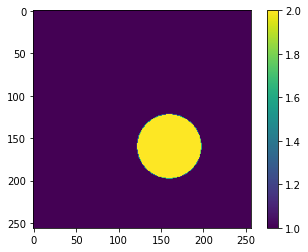

In [70]:
sos_map = c_discr.get_field_on_grid()(c_params)
plt.imshow(sos_map)
plt.colorbar()

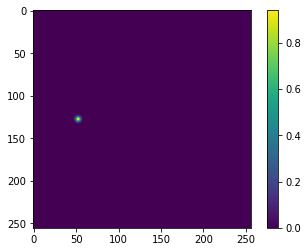

In [71]:
src_map = src_discr.get_field_on_grid()({})
plt.imshow(src_map.real)
plt.colorbar()

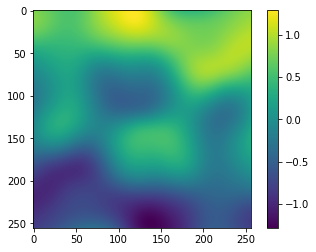

In [72]:
src_map = u_discr.get_field_on_grid()(u_params)
plt.imshow(src_map.real)
plt.colorbar()

In [73]:
src_map.shape

(256, 256, 1)

In [74]:
Hu = helmholtz(u=u, c=c, x=X)
global_params = Hu.get_global_params()

In [75]:
f = Hu.get_field(0)

In [76]:
x = jnp.asarray([2.,2.])
f(global_params,{"u": u_params, "c":c_params, "x":{}}, x).shape

(1,)

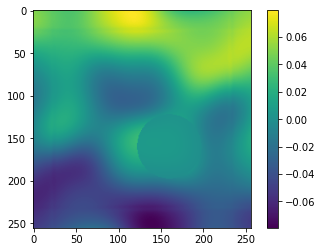

In [77]:
src_map = Hu.get_field_on_grid(0)(global_params,{"u": u_params, "c":c_params, "x":{}})
plt.imshow(src_map.real)
plt.colorbar()

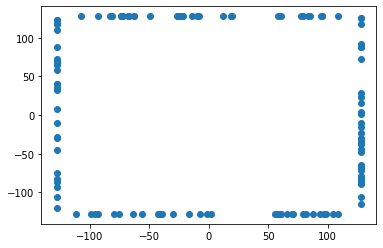

In [78]:
boundary_sampler = domain.boundary_sampler
x = boundary_sampler(seed, 128)
plt.scatter(x[:,0],x[:,1])

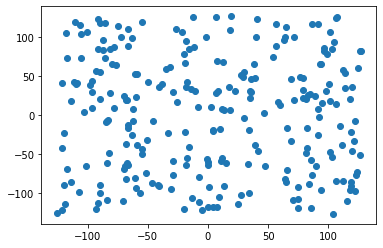

In [79]:
domain_sampler = domain.domain_sampler()
x = domain_sampler(seed, 256)
plt.scatter(x[:,0],x[:,1])

In [80]:
from jax import value_and_grad

f = Hu.get_field(0)
def helmholtz_fun(params, x):
    params_u, params_c = params
    return f(global_params,{"u": params_u, "c":params_c, "x":{}}, x)

# Defining losses
field = u_discr.get_field()
source_f = src.get_field()
def boundary_loss(params, seed, batchsize):
    x = boundary_sampler(seed, batchsize)
    field_val = jax.vmap(field, in_axes=(None,0))(params[0],x)
    return jnp.mean(jnp.abs(field_val)**2)

def domain_loss(params, seed, batchsize):
    x = domain_sampler(seed, batchsize)
    helm_val = jax.vmap(helmholtz_fun, in_axes=(None,0))(params,x)
    src_val = jax.vmap(source_f, in_axes=(None,0))(None, x)
    return jnp.sum(jnp.abs(src_val + helm_val))

def target_loss(params):
    x = jnp.asarray([0.,-75.])
    helm_val = helmholtz_fun(params,x)
    return -jnp.sum(jnp.abs(helm_val))

bound_valandgrad = jax.value_and_grad(boundary_loss)
domain_valandgrad = jax.value_and_grad(domain_loss)
target_valandgrad = jax.value_and_grad(target_loss)

def field_update(u_p, c_p, seed):
    seeds = random.split(seed, 2)
    params = [u_p, c_p]
    
    # losses f
    boundary_loss, b_gradient = bound_valandgrad(params, seeds[0], batch_size)
    domain_loss, d_gradient = domain_valandgrad(params, seeds[1], batch_size)
    gradient = tree_multimap(lambda x,y: 0.01*x+y, b_gradient, d_gradient)
    
    return boundary_loss, domain_loss, gradient[0]

def sos_update(u_p, c_p, seed):
    seeds = random.split(seed, 2)
    
    def one_step_loss(c_p):
        params = [u_p, c_p]
        
        # losses
        boundary_loss, b_gradient = bound_valandgrad(params, seeds[0], batch_size)
        domain_loss, d_gradient = domain_valandgrad(params, seeds[1], batch_size)
        gradient = tree_multimap(lambda x,y: 0.01*x+y, b_gradient, d_gradient)

        # Update field with simple SGD
        grad_fun = lambda x,y: x - 0.1*y
        params[0] = jax.tree_multimap(grad_fun,params[0],gradient[0])
    
        # Find the new field loss
        return target_loss(params)
    
    # Find gradient
    lossval, gradient = jax.value_and_grad(one_step_loss)(c_p)
    
    return lossval, gradient

@jax.jit
def update(opt_state, seed, k):
    seeds = random.split(seed, 2)
    u_p, c_p = get_params(opt_state)
    
    # Physics loss
    bl, domain_loss, u_grad = field_update(u_p, c_p, seeds[0])
    #targ_loss, c_grad = sos_update(u_p, c_p, seeds[1])
    targ_loss = 0.
    
    # Update parameters
    gradient = [u_grad, jax.tree_map(lambda x: x*0,c_p)]
    
    return bl, domain_loss, targ_loss, update_fun(k, gradient, opt_state)

In [81]:
import wandb

In [82]:
def log_image(wandb, field, name, step):
    plt.imshow(field[...,0].real, cmap='bone')
    plt.colorbar()
    img = wandb.Image(plt)
    wandb.log({name: img}, step=step)
    plt.close()

In [ ]:
from jax.experimental import optimizers
from jax.tree_util import tree_multimap
from jax import jit
from tqdm import tqdm

losshistory = []
batch_size = 512

init_fun, update_fun, get_params = optimizers.adam(.0001, b1=0.9, b2=0.99)
opt_state = init_fun([u_params, c_params])

pbar = tqdm(range(100000))
tol = 1e-3
rng = seed

wandb.init(project="helmholtz-pinn")


boundary_loss_h = 0.
domain_loss_h = 0.
targ_loss_h = 0.
f_grid = u_discr.get_field_on_grid()
for k in pbar:
    rng, seed = random.split(rng,2)
    bl, domain_loss, targ_loss, opt_state = update(opt_state, seed, k)
    losshistory.append(domain_loss)

    # For logging
    boundary_loss_h = boundary_loss_h + bl
    domain_loss_h = domain_loss_h + domain_loss
    targ_loss_h = targ_loss_h + targ_loss
    
    if (k+1) % 500 == 0:
        boundary_loss_h = boundary_loss_h / 500.
        domain_loss_h = domain_loss_h / 500.
        targ_loss_h = targ_loss_h/500.
        wandb.log(
            {
                'boundary_loss': boundary_loss_h, 
                'domain_loss': domain_loss_h,
                'target_loss': targ_loss_h
            }, step=k)
        pbar.set_description("B: {:01.4f} | D: {:01.4f} | T: {:01.4f}".format(
            jnp.log10(boundary_loss_h), 
            jnp.log10(domain_loss_h),
            jnp.log10(-targ_loss_h)
        ))
        boundary_loss_h = 0.
        domain_loss_h = 0.
        
        # Logging image
        f_grid = u_discr.get_field_on_grid()
        V = f_grid(get_params(opt_state)[0])
        log_image(wandb, V, "wavefield", k)
        
        c_grid = c_discr.get_field_on_grid()
        V = c_grid(get_params(opt_state)[1])
        log_image(wandb, V, "sos", k)


  0%|                                                                                        | 0/100000 [00:00<?, ?it/s]

boundary_loss,0.0
domain_loss,0.20802
target_loss,0.0
_runtime,171
_timestamp,1630866049
_step,29999


boundary_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
domain_loss,█▅▅▄▄▄▃▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
target_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆█
_timestamp,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: wandb version 0.12.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade

CondaError: Expected exactly one `egg-info` directory in '/home/antonios/repos/jaxdf', via egg-link 'lib/python3.8/site-packages/jaxdf.egg-link'. Instead found: ('jde.egg-info', 'jaxdf.egg-info').  These are often left over from legacy operations that did not clean up correctly.  Please remove all but one of these.



B: -5.1499 | D: -0.6351 | T: -inf:  13%|█████▏                                  | 12816/100000 [01:00<05:44, 253.05it/s]

In [24]:
f_grid = u_discr.get_field_on_grid()

In [59]:
V = f_grid(get_params(opt_state))

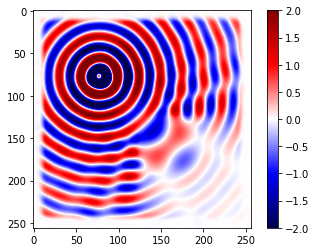

In [60]:
plt.imshow(V[...,0].real, cmap="seismic", vmin=-2, vmax=2)
plt.colorbar()

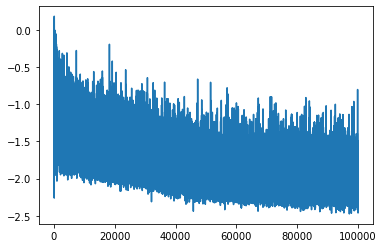

In [61]:
plt.plot(jnp.log10(jnp.asarray(losshistory)))